# Bayesian CNN

In [1]:
# imports
import tensorflow as tf
import tensorflow_probability as tfp # add probability distributions library

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tqdm import tqdm
from PIL import Image

In [2]:
# Paths to data
DATA_DIR = "C:/isic/"
DATASET_DIR = DATA_DIR + "datasets/"
IMAGE_DIR = DATA_DIR + "images/"
METADATA_DIR = DATA_DIR + "metadata/"
MODELS_DIR = DATA_DIR + "models/"

In [3]:
# Function to parse a single TFRecord
# The creation of this TFRecord format is specified in notebook 2

def parse_tfrecord_fn(sample):
    feature_description = {
        "image": tf.io.FixedLenFeature((224, 224, 3), tf.float32),
        "label": tf.io.FixedLenFeature((1,), tf.int64),
    }
    sample = tf.io.parse_single_example(sample, feature_description)
    
    return sample["image"], sample["label"]

In [4]:
# Load balanced dataset
isic_bal_tf = DATASET_DIR + "isic_no_duplicates_balanced.tfrecord"
isic_bal_tfrd = tf.data.TFRecordDataset(isic_bal_tf)
isic_bal = isic_bal_tfrd.map(parse_tfrecord_fn) # this is a map dataset, still not loading anything

# some testing
#isic_bal_images = isic_bal.map(lambda image, label: image)
#isic_bal_labels = isic_bal.map(lambda image, label: label)

In [5]:
# Load labels from CSV (faster than parsing each TFRecord)
# irrelevant for the balanced / small dataset
#isic_bal_csv = METADATA_DIR + "isic_trimmed_balanced.csv"
#isic_bal_df = pd.read_csv(isic_bal_csv)
#isic_bal_label_from_csv = isic_bal_df["target"].to_numpy()

In [5]:
# Manually split the dataset into training and validation
dataset_size = 1162  # number of images in the dataset - we know this from the CSV
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = int(0.1 * dataset_size)  # 10% for validation
# the rest 10% will be for testing

train_dataset = isic_bal.take(train_size)
remaining = isic_bal.skip(train_size) # the remaining 20%

val_dataset = remaining.take(val_size) # first 10% of the remaining data is for validation
test_dataset = remaining.skip(val_size) # the rest 10% is for testing

In [6]:
# Needs to access the data sequentially, just to confirm that the split is correct
# List loads the data into memory, so not suitable for large datasets.
debug = True
if debug:
    debug_full_size = len(list(isic_bal))
    debug_train_size = len(list(train_dataset))
    debug_val_size = len(list(val_dataset))
    debug_test_size = len(list(test_dataset))
    print(f"Size of the dataset: {debug_full_size} - 100%")
    print(f"Size of the training set: {debug_train_size} - {debug_train_size / debug_full_size * 100:.2f}%")
    print(f"Size of the validation set: {debug_val_size} - {debug_val_size / debug_full_size * 100:.2f}%")
    print(f"Size of the test set: {debug_test_size} - {debug_test_size / debug_full_size * 100:.2f}%")

Size of the dataset: 1162 - 100%
Size of the training set: 929 - 79.95%
Size of the validation set: 116 - 9.98%
Size of the test set: 117 - 10.07%


In [7]:
# Shuffle and batch the train and validation datasets
batch_size = 32 # split images into batches of 32

# batch, shuffle and prefetch to the training set
train_batched = (
    train_dataset.shuffle(
        buffer_size=1000, seed=111
    ) 
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

# batch and prefetch to the validation set
val_batched = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
# Based on the previous CNN model
# CONV2D change to Convolution2DFlipout which is a Bayesian layer taking into account the uncertainty of the weights
# DENSE change to DenseFlipout which is a Bayesian layer taking into account the uncertainty of the weights
model = tf.keras.Sequential(
    [
        tfp.layers.Convolution2DFlipout(
            32, (3, 3), activation="relu", input_shape=(224, 224, 3) # match shape of our images
        ),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tfp.layers.Convolution2DFlipout(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tfp.layers.Convolution2DFlipout(64, (3, 3), activation="relu"),
        tf.keras.layers.Flatten(),
        tfp.layers.DenseFlipout(64, activation="relu"),
        tfp.layers.DenseFlipout(
            1, activation="sigmoid"
        ),  # Binary classification, so use sigmoid activation with single output
    ]
)

c:\Users\matt\miniconda3\envs\tf\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
c:\Users\matt\miniconda3\envs\tf\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [9]:
# Note number of parameters
# Total params: 22,263,841 vs 11,132,033 in the CNN model -> double the number of parameters
# Trainable params: 22,263,841 vs 11,132,033 in the CNN model -> double the number of parameters
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_flipout (Conv2DFlipo  (None, 222, 222, 32)     1760      
 ut)                                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_flipout_1 (Conv2DFli  (None, 109, 109, 64)     36928     
 pout)                                                           
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_flipout_2 (Conv2DFli  (None, 52, 52, 64)       7

In [10]:
# Compile the model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
# Testing callbacks to train on large number of epochs and save the best model
# Results are inconclusive, but functions are kept for future reference

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)

# Model checkpoint callback
save_best = tf.keras.callbacks.ModelCheckpoint(
    MODELS_DIR + "4_BCNN_isic_balanced_best.h5", monitor="val_accuracy", save_best_only=True
)

# Training Callbacks
callbacks = [early_stopping, save_best]

In [11]:
# Train the model
training = model.fit(
    train_batched,
    epochs=20, # was 100+ with callbacks, but no improvements
    validation_data=val_batched,
    #callbacks=callbacks, # uncomment to use callbacks
)

Epoch 1/20
30/30 [==============================] - 14s 263ms/step - loss: 28008880.0000 - accuracy: 0.5038 - val_loss: 27825122.0000 - val_accuracy: 0.5603
Epoch 2/20
30/30 [==============================] - 6s 194ms/step - loss: 27666700.0000 - accuracy: 0.5285 - val_loss: 27487342.0000 - val_accuracy: 0.5172
Epoch 3/20
30/30 [==============================] - 6s 191ms/step - loss: 27331798.0000 - accuracy: 0.5091 - val_loss: 27155222.0000 - val_accuracy: 0.4741
Epoch 4/20
30/30 [==============================] - 6s 191ms/step - loss: 27001462.0000 - accuracy: 0.4855 - val_loss: 26826636.0000 - val_accuracy: 0.4569
Epoch 5/20
30/30 [==============================] - 6s 192ms/step - loss: 26674036.0000 - accuracy: 0.5113 - val_loss: 26500364.0000 - val_accuracy: 0.5517
Epoch 6/20
30/30 [==============================] - 6s 192ms/step - loss: 26348568.0000 - accuracy: 0.5156 - val_loss: 26175718.0000 - val_accuracy: 0.5776
Epoch 7/20
30/30 [==============================] - 6s 192ms/st

In [12]:
# Save the model and history for reference
model.save(MODELS_DIR + "4_BCNN_balanced.h5")
np.save(MODELS_DIR + "4_BCNN_balanced_history.npy", training.history)

In [ ]:
# load the model and history if not retraining
# model = tf.keras.models.load_model(MODELS_DIR + "4_BCNN_balanced.h5")
# history = np.load(MODELS_DIR + "4_BCNN_balanced_history.npy", allow_pickle=True).item()

In [13]:
# adapt if loading from history
history = training.history

In [14]:
# analyze the training and validation results
print("Final training accuracy: ", history["accuracy"][-1])
print("Final training loss: ", history["loss"][-1])

print("Final validation accuracy: ", history["val_accuracy"][-1])
print("Final validation loss: ", history["val_loss"][-1])

Final training accuracy:  0.49192678928375244
Final training loss:  21881634.0
Final validation accuracy:  0.5431034564971924
Final validation loss:  21714346.0


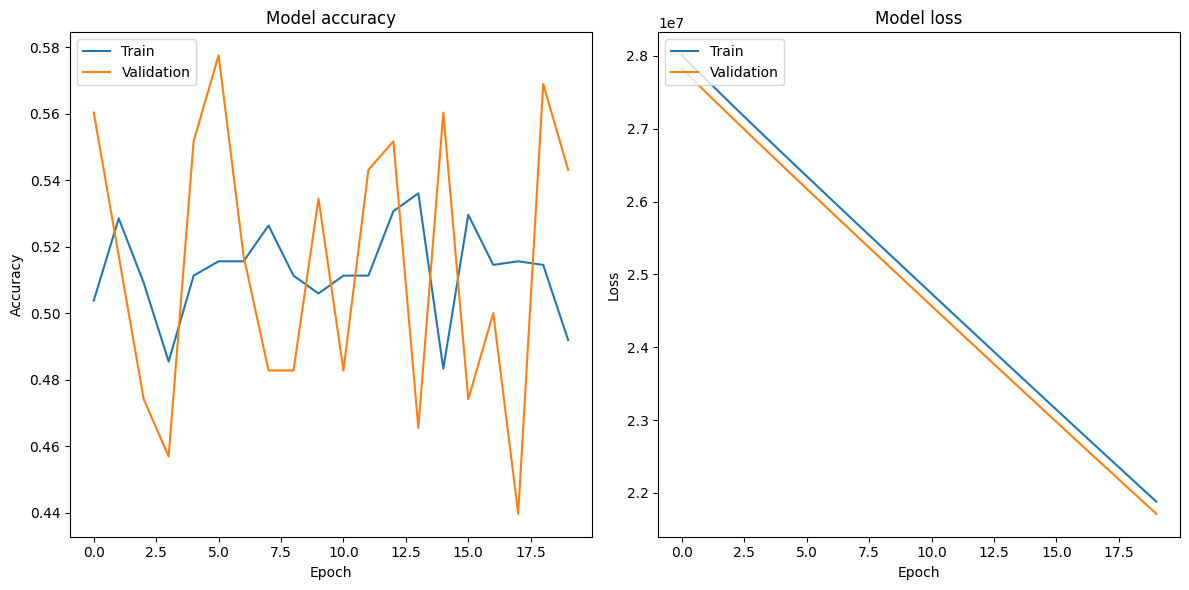

In [15]:
# Create a new figure
plt.figure(figsize=(12, 6))

# Subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

# Subplot for loss
plt.subplot(1, 2, 2)
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

# Display the plots
plt.tight_layout()
plt.show()

## Testing on the test set

In [16]:
test_dataset_batched = test_dataset.batch(batch_size)
test_loss, test_accuracy = model.evaluate(test_dataset_batched, verbose=2)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)

4/4 - 1s - loss: 21714346.0000 - accuracy: 0.4786 - 1s/epoch - 305ms/step
Test accuracy: 0.47863247990608215
Test loss: 21714346.0


## Exploring probabilities in a Bayesian CNN

In [17]:
# Extract a single batch from the test set
for image, label in test_dataset.take(1):
    print("Original shape:", image.shape)
    # Add an extra dimension to represent the batch size
    image_batch = tf.expand_dims(image, axis=0)
    print("New shape:", image_batch.shape)

Original shape: (224, 224, 3)
New shape: (1, 224, 224, 3)


In [18]:
# Make a prediction on the sample image
prediction1 = model.predict(image_batch)
prediction1

1/1 [==============================] - 1s 723ms/step


array([[0.500174]], dtype=float32)

In [19]:
# Let's make a new prediction with the same image
prediction2 = model.predict(image_batch)
prediction2

1/1 [==============================] - 0s 142ms/step


array([[0.4809097]], dtype=float32)

In [20]:
# Check if the predictions are the same
predictions = np.array_equal(prediction1, prediction2)
print(f"Is prediction1 equal to prediction2? {predictions}")

Is prediction1 equal to prediction2? False


In contrast to a CNN, the results from a Bayesian CNN are depended on the distributions

## Dive into multiple runs

In [21]:
# Run the model multiple times
num_runs = 100
outputs = np.zeros((num_runs, 1))
for i in range(num_runs):
    outputs[i] = model.predict(image_batch)

1/1 [==============================] - 0s 21ms/step


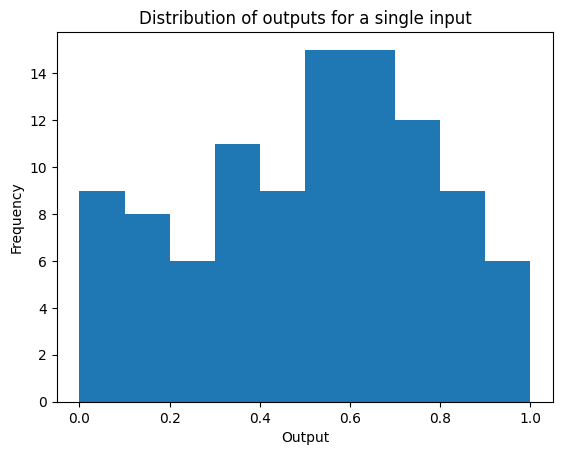

In [22]:
# Plot the distribution of outputs
plt.hist(outputs, bins=10, range=(0, 1))
plt.title("Distribution of outputs for a single input")
plt.xlabel("Output")
plt.ylabel("Frequency")
plt.show()

In [23]:
# Calculate statistics
mean = np.mean(outputs)
max_value = np.max(outputs)
min_value = np.min(outputs)
std_dev = np.std(outputs)

# Print statistics
print(f"Mean: {mean}")
print(f"Max: {max_value}")
print(f"Min: {min_value}")
print(f"Standard Deviation: {std_dev}")

Mean: 0.5135145295294933
Max: 0.9891079664230347
Min: 0.003122585592791438
Standard Deviation: 0.2604065485731975


In [26]:
from scipy import stats

# Round the outputs to get the predicted classes
predicted_classes = np.round(outputs)

# Find the most common class
most_common_class = stats.mode(predicted_classes)[0]

print(f"Most common class: {most_common_class}")
print(f"True class: {label}")

Most common class: [1.]
True class: [1]


In [29]:
# Count the number of occurrences of each class
predicted_classes_int = np.round(outputs).astype(int)
counts = np.bincount(predicted_classes_int.flatten())

# Calculate the percentage of predictions in each class
percentages = counts / num_runs * 100

# Print the percentages
for i, percentage in enumerate(percentages):
    print(f"Percentage in class {i}: {percentage}%")

Percentage in class 0: 43.0%
Percentage in class 1: 56.99999999999999%


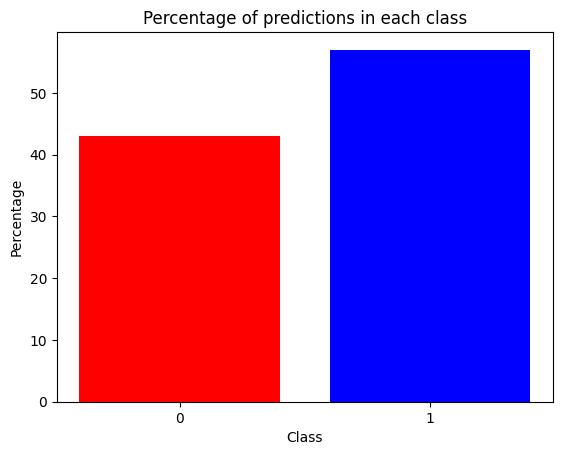

In [32]:
# Define colors
colors = ["blue" if i == label else "red" for i in range(len(percentages))]

# Create a bar plot
plt.bar(range(len(percentages)), percentages, color=colors)

# Set x-ticks
plt.xticks(range(len(percentages)))

# Add labels and title
plt.xlabel("Class")
plt.ylabel("Percentage")
plt.title("Percentage of predictions in each class")

# Show the plot
plt.show()

The model predicts class the correct class one 57% of the time, while the incorrect class 43% of the time out of a 100 runs.